In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kmodes.kmodes import KModes
from sklearn.ensemble import IsolationForest
from xgboost import XGBRegressor
from xgboost import plot_importance


import warnings
warnings.filterwarnings('ignore')


pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_excel('/Users/ilya/Desktop/data_all.xlsx')

In [3]:
df.head()

,Unnamed: 0,id,uri,lat,lng,price,currency,key_offer_type,key_disposition,surface,...,school,kindergarten,sport_field,playground,condition,property_type,building_type,penb,deposit,deposit_by_price
0,0,710805,710805-nabidka-pronajem-bytu-hlavackova-praha,50.069999,14.382026,22500,CZK,pronajem,1-kk,35,...,219,756,1073,529,None,Osobní,None,None,37500.0,1.666667
1,2,710803,710803-nabidka-pronajem-bytu-veletrzni-brno,49.188190,16.588290,10000,CZK,pronajem,1-1,38,...,554,212,777,1017,Velmi dobrý,Osobní,Cihla,G,10000.0,1.000000
2,4,710797,710797-nabidka-pronajem-bytu-michelska-hlavni-...,50.051150,14.457670,16000,CZK,pronajem,3-kk,78,...,348,604,641,358,Dobrý,Osobní,Cihla,G,21000.0,1.312500
3,7,710794,710794-nabidka-pronajem-bytu-korunni-praha,50.075535,14.445289,37500,CZK,pronajem,2-kk,60,...,519,216,542,280,None,Osobní,None,None,62500.0,1.666667
4,8,710789,710789-nabidka-pronajem-bytu-k-hajku,49.692797,18.347021,9850,CZK,pronajem,3-1,78,...,170,329,734,120,Velmi dobrý,Osobní,Panel,D,19700.0,2.000000


In [4]:
df.drop(['Unnamed: 0', 'id', 'uri', 'currency', 'deposit_by_price'], axis=1, inplace=True)

In [5]:
df['floor'] = df['floor'].apply(lambda x: 'above_6' if x > 6 else x)

df['floor'] = df['floor'].astype('category')

In [6]:
AREA_INFO_ATTRIBUTES = ['public_transport_stop', 'post_office', 'store', 'bank', 'restaurant', 
                       'pharmacy', 'school', 'kindergarten', 'sport_field', 'playground']

BINARY_ATTRIBUTES = ['balcony', 'terrace', 'cellar', 'loggia', 'parking', 'elevator', 'garage']

In [7]:
df.columns

Index(['lat', 'lng', 'price', 'key_offer_type', 'key_disposition', 'surface',
       'utilities', 'facilities', 'floor', 'balcony', 'terrace', 'cellar',
       'loggia', 'parking', 'elevator', 'garage', 'public_transport_stop',
       'post_office', 'store', 'bank', 'restaurant', 'pharmacy', 'school',
       'kindergarten', 'sport_field', 'playground', 'condition',
       'property_type', 'building_type', 'penb', 'deposit'],
      dtype='object')

### Helper functions

In [8]:
def convert_to_dummies(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Converts dataframe categorical columns to dummies
    """
    
    df_copy = df.copy()
    
    df_dummies = pd.get_dummies(df_copy[columns])

    df_copy.drop(columns, axis=1, inplace=True)
    
    df_copy = pd.concat([df_copy, df_dummies], axis=1)
    
    columns_to_drop = []
    
    for column in df_copy:
        
        # Remove meaningless columns 
        if 'none' in column.lower() or 'ostatní' in column.lower():
            columns_to_drop.append(column)
            
    df_copy.drop(columns_to_drop, axis=1, inplace=True)

    df_dummies = df_copy
    
    return df_dummies

In [9]:
def print_reg_metrics(y_test: pd.Series, y_pred: np.ndarray) -> None:
    """
    Prints out basic evaluation metrics of regression models.
    """
    
    score = r2_score(y_test, y_pred)
    
    print(f'R2 -------------------------- {round(score, 3)} ({int(round(score * 100, 0))} %)')
    print(f'Mean squared error ---------- {round(mean_squared_error(y_test, y_pred), 1)}')
    print(f'Root mean squared error ----- {round(np.sqrt(mean_squared_error(y_test, y_pred)), 1)}')

    

In [10]:
def mean_r2_score(X: pd.Series, Y: pd.Series, model, n_iter: int) -> None:
    """
    Prints mean R2 score of regression model based on N interations.
    """
    
    r2_scores = []
    
    for _ in range(n_iter):
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

        model.fit(x_train, y_train)

        y_prediction =  model.predict(x_test)

        score = r2_score(y_test, y_prediction)

        if score > 0:
            r2_scores.append(score)
    
    mean_r2_score = sum(r2_scores) / len(r2_scores)
    
    print(f'Mean R2 score based on {n_iter} iterations ----- {round(mean_r2_score, 3)} ({int(round(mean_r2_score*100, 0))} %)')
    

In [11]:
def mean_accuracy_score(X: pd.Series, Y: pd.Series, models: list, n_iter: int, plot_feature_importance=True) -> None:
    """
    Prints mean accuracy score of classification model based on N interations. 
    Also plots features importance barchart for models DTC and RFC.
    """
    
    accuracy_scores = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)
    
    # Separator ('-') length
    model_sep = {'SVC()': 31,
                 'KNeighborsClassifier()': 14,
                 'GaussianNB()': 24,
                 'DecisionTreeClassifier()': 12,
                 'RandomForestClassifier()': 12}
    
    plt.rcParams['figure.figsize'] = (20, 50)
    plt.rc('font', size=20) 
    
    i = 0
    
    for model in models:
        model_scores = []
        
        for _ in range(n_iter):
            model.fit(X_train, y_train)

            model_prediction = model.predict(X_test)

            score = accuracy_score(model_prediction, y_test)
            model_scores.append(score)
        
        mean_model_score = sum(model_scores) / len(model_scores)
        
        accuracy_scores.append(f'{str(model).replace("()", "")} {"-"*model_sep[str(model)]} {round(mean_model_score, 3)} ({int(round(mean_model_score*100, 0))} %)')
        
        if plot_feature_importance:
            try:
                ax = plt.subplot(2, 1, i+1)

                coef = pd.Series(model.feature_importances_, index = X.columns)
                imp_coef = coef.sort_values()

                imp_coef.plot(kind='barh', color='#00957d', ax=ax)

                ax.set_title(f'Feature importance using {str(model).replace("()", "")}')
                plt.savefig(f'{str(model)}.png', bbox_inches='tight', facecolor='w')

                i += 1

            except:
                pass
        
            
    print(*accuracy_scores, sep='\n')
    
    

In [12]:
def eval_lasso_ridge(X: pd.Series, Y: pd.Series, model, plot_feature_importance=True) -> None:
    """
    Prints the evaluation of Lasso / Ridgre regression model.
    Also plots features importance barchart.
    """
    
    model_name = 'LassoCV model' if 'LassoCV' in str(model) else 'RidgeCV model'
    
    print(f'Best alpha using {model_name} -------------- {round(model.alpha_, 2)}')
    print(f'Best score using {model_name} -------------- {round(model.score(X, Y), 3)} ({int(round(model.score(X, Y)*100, 0))} %)')

    coef = pd.Series(model.coef_, index = X.columns)

    print(f'Number of choosen features ------------------ {str(sum(coef != 0))}')
    print(f'Number of droped features ------------------- {str(sum(coef == 0))}')

    imp_coef = coef.sort_values()
    
    if plot_feature_importance:
        plt.rcParams['figure.figsize'] = (12, 20)
        plt.rc('font', size=15) 
        imp_coef.plot(kind='barh', color='#00957d')
        plt.title(f'Feature importance using {model_name}')
        plt.savefig(f'{model_name}.png', bbox_inches='tight', facecolor='w')
    

In [13]:
def eval_classification_by_offer_type(models: list, data: list, dummies_attr: list, target: str) -> None:
    """
    Prints the evaluation of classification models divided by offer type (rent, sell, all).
    """
    
    for i, elem in enumerate([df_rent, df_sell, df_all]):
        df_dummies = convert_to_dummies(elem, dummies_attr)

        X = df_dummies.drop(target, axis=1)
        Y = df_dummies[target]

        offer_type = {0: 'RENT', 1: 'SELL', 2: 'ALL'}

        print(f'******************************* {offer_type[i]} *******************************\n')
        mean_accuracy_score(X, Y, models, 5, plot_feature_importance=False)
        print('\n')

In [14]:
def find_optimum_n_clusters_elbow(data: pd.DataFrame, kmodes: bool = False) -> None:
    """
    Finds optimum number of clusters for K-means model using the "elbow" method.
    """
   
    ssd = []

    if kmodes:
        K = range(1, 10)
        for k in K:
            kmodes = KModes(n_clusters=k, n_init=5)
            kmodes.fit_predict(data)
            ssd.append(kmodes.cost_)
    else:  
        K = range(1, 30)
        for k in K:
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(data)
            ssd.append(kmeans.inertia_)
        

    plt.plot(K, ssd, 'bx-')
    plt.xlabel("Distance Residual Sums for K Values (WCSS)")
    plt.title("Elbow Method for Optimum Number of Clusters")
    plt.rcParams['figure.figsize'] = (12, 5)

    plt.show()

In [15]:
def evaluate_kmeans(data: pd.DataFrame, n: int) -> KMeans:
    """
    Prints the evaluation of K-means model with n-clusters.
    """
    
    kmeans = KMeans(n_clusters=n).fit(data)
    score = silhouette_score(data, kmeans.labels_, metric='euclidean')
    
    print(f'Silhouette score for {n} clusters --------- {round(score, 3)}')
    
    return kmeans

In [16]:
def remove_outliers(column: pd.Series) -> pd.Series:
    """
    Removes outliers from provided column using IQR method.
    """
    
    column_new = column.copy()
    
    Q1 = column_new.quantile(0.25)
    Q3 = column_new.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    column_new = column_new.apply(lambda x: x if x > lower and x < upper else np.nan)
    
    while column_new.isnull().sum() > 0:

        column_new.fillna(column_new.mean(), inplace=True)
        Q1 = column_new.quantile(0.25)
        Q3 = column_new.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR


        column_new = column_new.apply(lambda x: x if x > lower and x < upper else np.nan)
       
        
    column_new = column_new.apply(lambda x: x if x > lower and x < upper else np.nan)
    
    return column_new


In [17]:
def create_df_with_clusters(data: pd.DataFrame, attr_type: str) -> pd.DataFrame:
    """
    Creates a DataFrame with clusters. The result depends on attribute type:
        - attr_type = 'num' -> return median values for each cluster
        - attr_type = 'cat' -> return mode values for each cluster
    
    Note: Provided DataFrame should aready contain 'cluster' column.
    """
    
    clusters = []

    for i in range(len(data['cluster'].unique())):
        cluster = data[data['cluster'] == i]
        
        if attr_type == 'num':
            values = cluster.drop('cluster', axis=1).describe().loc['50%']
        elif attr_type == 'cat':
            values = cluster.drop('cluster', axis=1).describe().loc['top']
        else:
            print(f'{attr_type} is not a valid attribute type. Could be only "num" or "cat".')
            return
            
        count = len(cluster)
        row = [f'cluster_{i+1}', count] + values.tolist()
        clusters.append(row)

    clusters_df = pd.DataFrame(clusters, columns=['cluster', 'count'] + data.drop('cluster', axis=1).columns.tolist())    
    
    return clusters_df

## Regression models

### Predicting price (rent)

In [18]:
df_rent = df[df['key_offer_type'] == 'pronajem']
df_rent.drop(['key_offer_type'], axis=1, inplace=True)

In [19]:
df_rent_dummies = convert_to_dummies(df_rent, ['facilities', 'condition', 'property_type', 'building_type', 'penb', 
                                          'key_disposition', 'floor'])

In [20]:
X_rent = df_rent_dummies.drop('price', axis=1)
Y_rent = df_rent_dummies['price']

X_rent = (X_rent - X_rent.mean()) / X_rent.std()

x_rent_train, x_rent_test, y_rent_train, y_rent_test = train_test_split(X_rent, Y_rent, test_size = 0.2, random_state = 12)

#### Linear Regression

In [21]:
lin_reg_rent = LinearRegression()
lin_reg_rent.fit(x_rent_train, y_rent_train)

y_rent_prediction =  lin_reg_rent.predict(x_rent_test)

In [22]:
print_reg_metrics(y_rent_test, y_rent_prediction)

R2 -------------------------- 0.834 (83 %)
Mean squared error ---------- 9081387.4
Root mean squared error ----- 3013.5


In [23]:
adjusted_r2 = 1-(1-lin_reg_rent.score(X_rent, Y_rent))*(len(Y_rent)-1)/(len(Y_rent)-X_rent.shape[1]-1)
adjusted_r2

0.7846584249906013

In [24]:
mean_r2 = mean_r2_score(X_rent, Y_rent, lin_reg_rent, 100)
mean_r2

Mean R2 score based on 100 iterations ----- 0.753 (75 %)


#### Lasso Regression

In [25]:
lasso_reg_rent = LassoCV(cv=5, random_state=17, max_iter=10000)
lasso_reg_rent.fit(x_rent_train, y_rent_train)

y_rent_prediction = lasso_reg_rent.predict(x_rent_test)

print_reg_metrics(y_rent_test, y_rent_prediction)

R2 -------------------------- 0.84 (84 %)
Mean squared error ---------- 8708558.5
Root mean squared error ----- 2951.0


In [26]:
mean_r2 = mean_r2_score(X_rent, Y_rent, lasso_reg_rent, 100)
mean_r2

Mean R2 score based on 100 iterations ----- 0.766 (77 %)


Best alpha using LassoCV model -------------- 96.27
Best score using LassoCV model -------------- 0.784 (78 %)
Number of choosen features ------------------ 32
Number of droped features ------------------- 28


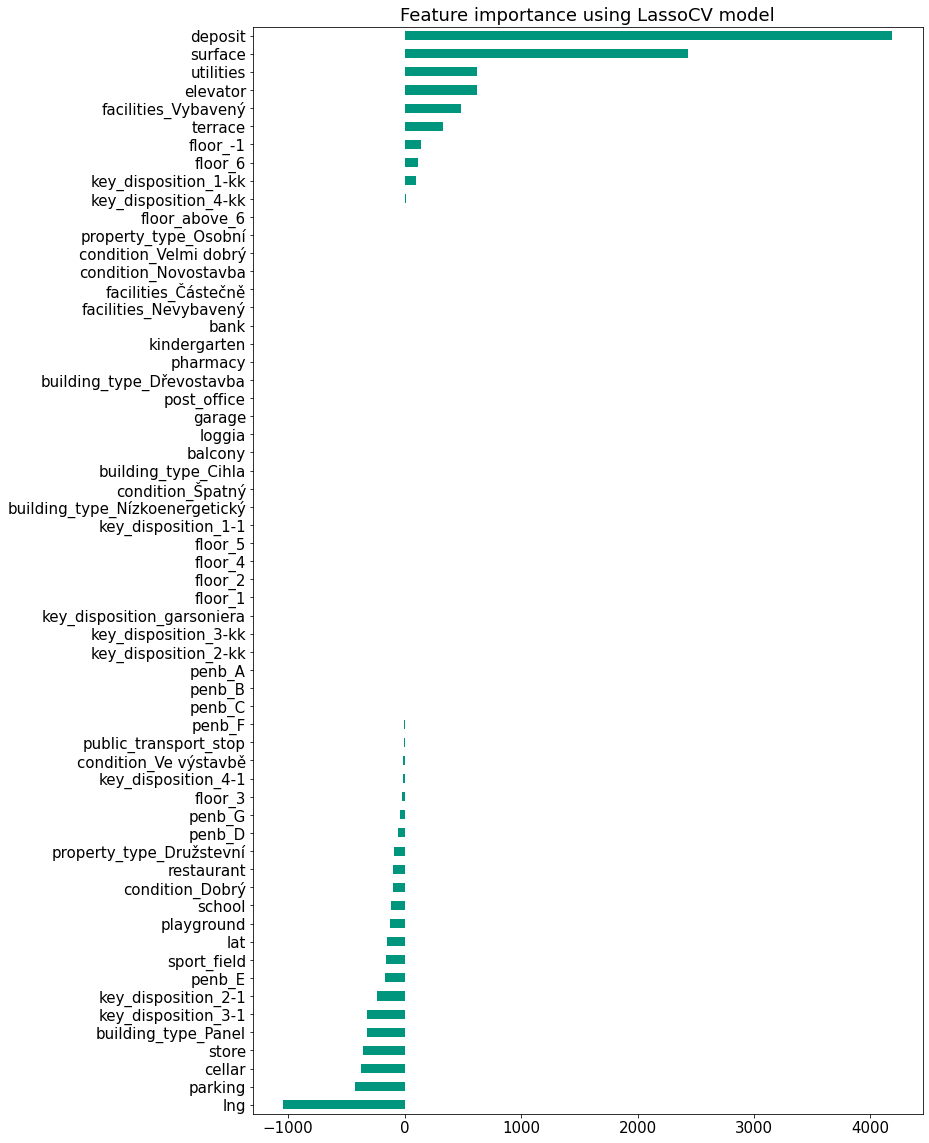

In [27]:
eval_lasso_ridge(X_rent, Y_rent, lasso_reg_rent, plot_feature_importance=True)

#### Ridge Regression

In [28]:
ridge_reg_rent = RidgeCV()
ridge_reg_rent.fit(x_rent_train, y_rent_train)

y_rent_prediction = ridge_reg_rent.predict(x_rent_test)

print_reg_metrics(y_rent_test, y_rent_prediction)

R2 -------------------------- 0.834 (83 %)
Mean squared error ---------- 9039289.9
Root mean squared error ----- 3006.5


In [29]:
mean_r2 = mean_r2_score(X_rent, Y_rent, ridge_reg_rent, 100)
mean_r2

Mean R2 score based on 100 iterations ----- 0.759 (76 %)


Best alpha using RidgeCV model -------------- 10.0
Best score using RidgeCV model -------------- 0.789 (79 %)
Number of choosen features ------------------ 60
Number of droped features ------------------- 0


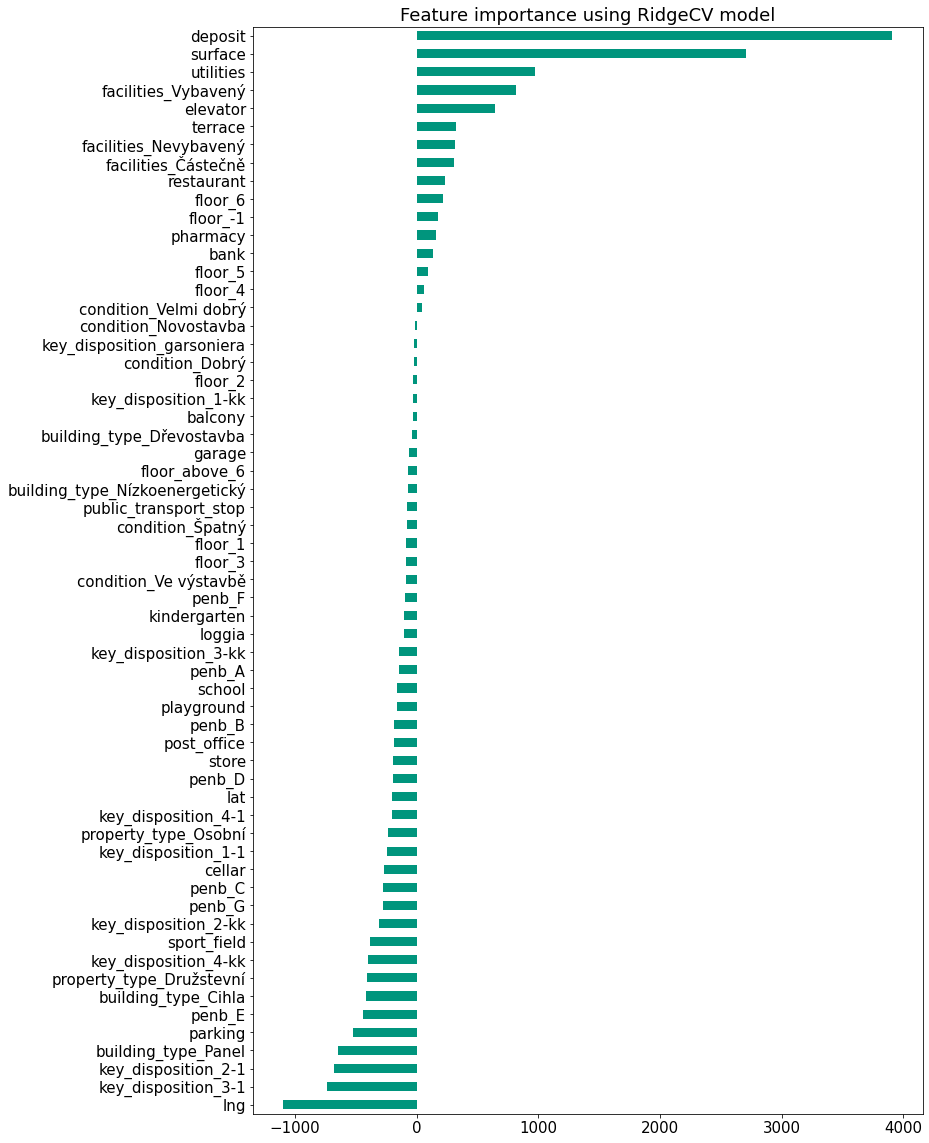

In [30]:
eval_lasso_ridge(X_rent, Y_rent, ridge_reg_rent, plot_feature_importance=True)

### Predicting utilities (rent)

In [31]:
df_rent = df[df['key_offer_type'] == 'pronajem']
df_rent.drop(['key_offer_type'], axis=1, inplace=True)

In [32]:
df_rent_dummies = convert_to_dummies(df_rent, ['facilities', 'condition', 'property_type', 'building_type', 'penb', 
                                          'key_disposition', 'floor'])

In [33]:
X_rent = df_rent_dummies.drop('utilities', axis=1)
Y_rent = df_rent_dummies['utilities']

X_rent = (X_rent - X_rent.mean()) / X_rent.std()

x_rent_train, x_rent_test, y_rent_train, y_rent_test = train_test_split(X_rent, Y_rent, test_size = 0.2, random_state = 17)

#### Linear Regression

In [34]:
lin_reg_rent = LinearRegression()
lin_reg_rent.fit(x_rent_train, y_rent_train)

y_rent_prediction =  lin_reg_rent.predict(x_rent_test)

In [35]:
print_reg_metrics(y_rent_test, y_rent_prediction)

R2 -------------------------- 0.592 (59 %)
Mean squared error ---------- 4227527.9
Root mean squared error ----- 2056.1


In [36]:
mean_r2 = mean_r2_score(X_rent, Y_rent, lin_reg_rent, 100)
mean_r2

Mean R2 score based on 100 iterations ----- 0.58 (58 %)


#### Lasso Regression

In [37]:
lasso_reg_rent = LassoCV(cv=5, random_state=17, max_iter=10000)
lasso_reg_rent.fit(x_rent_train, y_rent_train)

y_rent_prediction = lasso_reg_rent.predict(x_rent_test)

print_reg_metrics(y_rent_test, y_rent_prediction)

R2 -------------------------- 0.598 (60 %)
Mean squared error ---------- 4165896.2
Root mean squared error ----- 2041.1


In [38]:
mean_r2 = mean_r2_score(X_rent, Y_rent, lasso_reg_rent, 100)
mean_r2

Mean R2 score based on 100 iterations ----- 0.582 (58 %)


Best alpha using LassoCV model -------------- 15.81
Best score using LassoCV model -------------- 0.603 (60 %)
Number of choosen features ------------------ 49
Number of droped features ------------------- 11


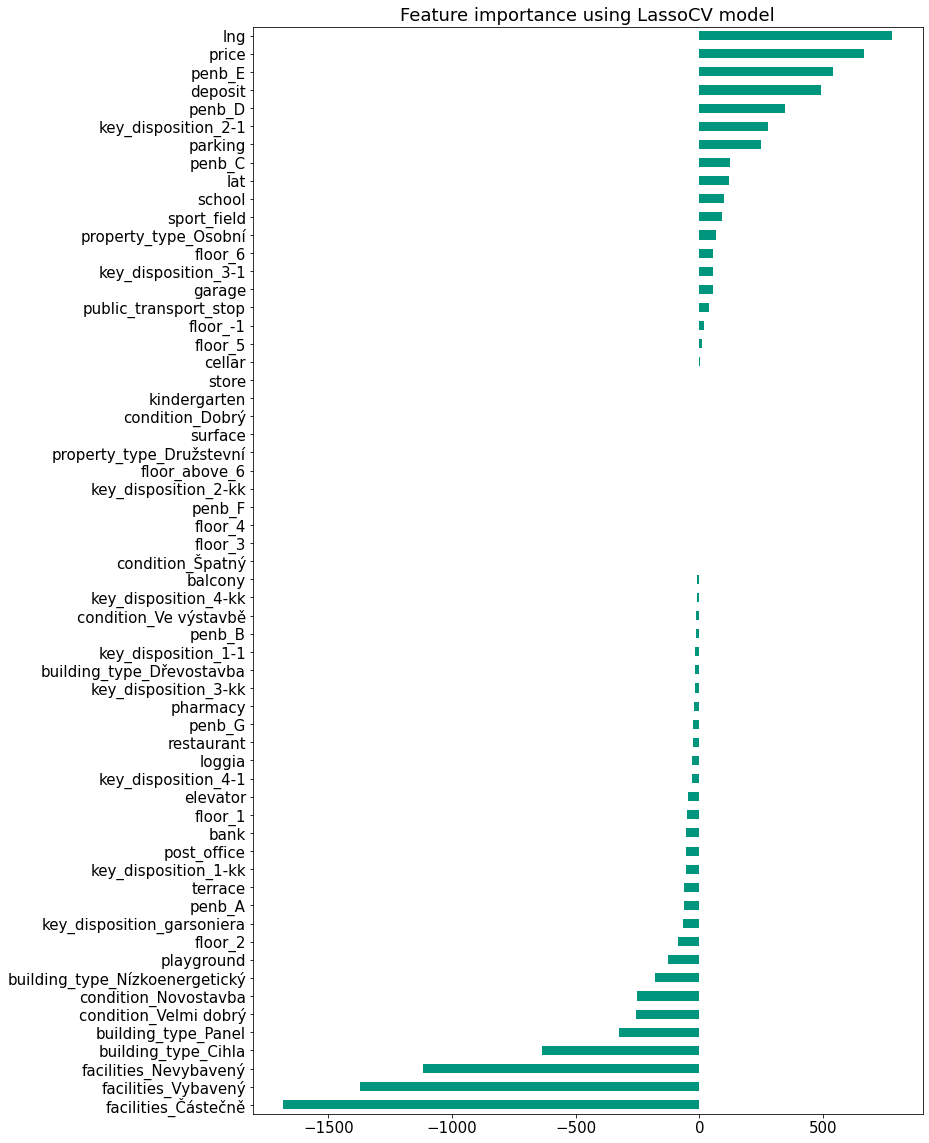

In [39]:
eval_lasso_ridge(X_rent, Y_rent, lasso_reg_rent, plot_feature_importance=True)

#### Ridge Regression

In [40]:
ridge_reg_rent = RidgeCV()
ridge_reg_rent.fit(x_rent_train, y_rent_train)

y_rent_prediction = ridge_reg_rent.predict(x_rent_test)

print_reg_metrics(y_rent_test, y_rent_prediction)

R2 -------------------------- 0.592 (59 %)
Mean squared error ---------- 4223358.7
Root mean squared error ----- 2055.1


In [41]:
mean_r2 = mean_r2_score(X_rent, Y_rent, ridge_reg_rent, 100)
mean_r2

Mean R2 score based on 100 iterations ----- 0.572 (57 %)


Best alpha using RidgeCV model -------------- 10.0
Best score using RidgeCV model -------------- 0.607 (61 %)
Number of choosen features ------------------ 60
Number of droped features ------------------- 0


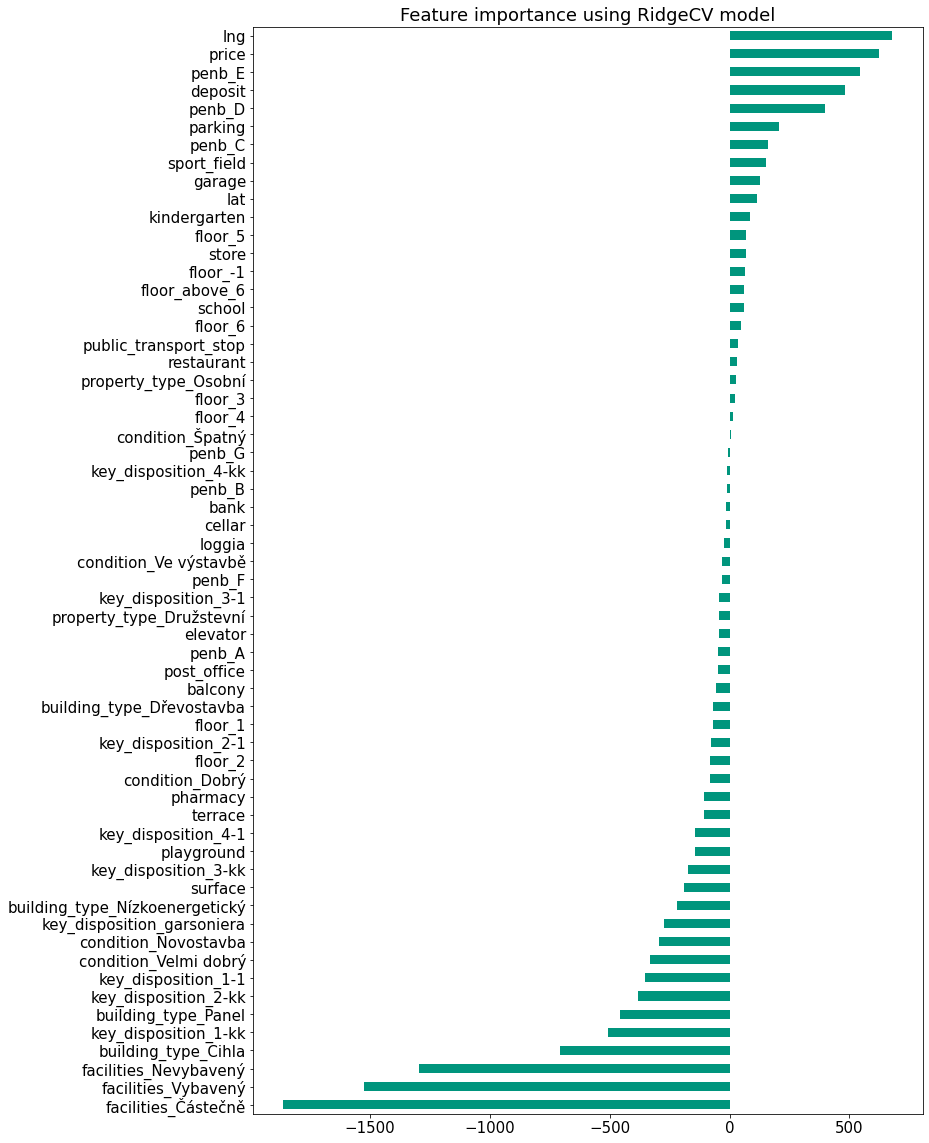

In [42]:
eval_lasso_ridge(X_rent, Y_rent, ridge_reg_rent, plot_feature_importance=True)

### Predicting price (sell)

In [43]:
df_sell = df[df['key_offer_type'] == 'prodej']
df_sell.drop(['key_offer_type', 'utilities', 'deposit'], axis=1, inplace=True)

In [44]:
df_sell_dummies = convert_to_dummies(df_sell, ['facilities', 'condition', 'property_type', 'building_type', 'penb', 
                                          'key_disposition', 'floor'])

In [45]:
X_sell = df_sell_dummies.drop('price', axis=1)
Y_sell = df_sell_dummies['price']

X_sell = (X_sell - X_sell.mean()) / X_sell.std()

x_sell_train, x_sell_test, y_sell_train, y_sell_test = train_test_split(X_sell, Y_sell, test_size = 0.2, random_state = 17)

#### Linear Regression

In [46]:
lin_reg_sell = LinearRegression()
lin_reg_sell.fit(x_sell_train, y_sell_train)

y_sell_prediction =  lin_reg_sell.predict(x_sell_test)

In [47]:
print_reg_metrics(y_sell_test, y_sell_prediction)

R2 -------------------------- 0.568 (57 %)
Mean squared error ---------- 6563254896576.6
Root mean squared error ----- 2561885.0


In [48]:
mean_r2 = mean_r2_score(X_sell, Y_sell, lin_reg_sell, 100)
mean_r2

Mean R2 score based on 100 iterations ----- 0.518 (52 %)


#### Lasso Regression

In [49]:
lasso_reg_sell = LassoCV(cv=5, random_state=17, max_iter=10000)
lasso_reg_sell.fit(x_sell_train, y_sell_train)

y_sell_prediction = lasso_reg_sell.predict(x_sell_test)

print_reg_metrics(y_sell_test, y_sell_prediction)

R2 -------------------------- 0.623 (62 %)
Mean squared error ---------- 5739644392241.1
Root mean squared error ----- 2395755.5


In [50]:
mean_r2 = mean_r2_score(X_sell, Y_sell, lasso_reg_sell, 100)
mean_r2

Mean R2 score based on 100 iterations ----- 0.548 (55 %)


Best alpha using LassoCV model -------------- 79444.32
Best score using LassoCV model -------------- 0.597 (60 %)
Number of choosen features ------------------ 35
Number of droped features ------------------- 23


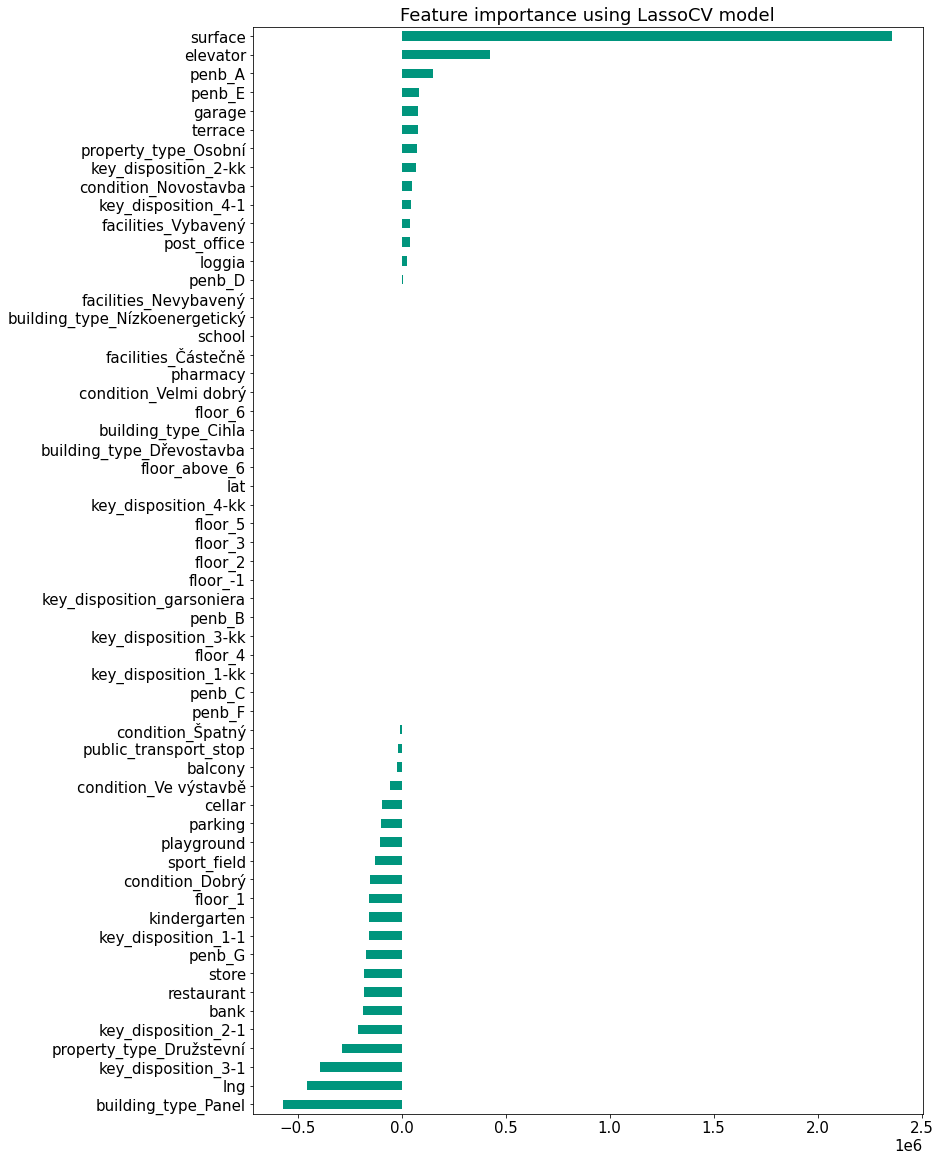

In [51]:
eval_lasso_ridge(X_sell, Y_sell, lasso_reg_sell, plot_feature_importance=True)

#### Ridge Regression

In [52]:
ridge_reg_sell = RidgeCV()
ridge_reg_sell.fit(x_sell_train, y_sell_train)

y_sell_prediction = ridge_reg_sell.predict(x_sell_test)

print_reg_metrics(y_sell_test, y_sell_prediction)

R2 -------------------------- 0.582 (58 %)
Mean squared error ---------- 6356131248951.5
Root mean squared error ----- 2521136.9


In [53]:
mean_r2 = mean_r2_score(X_sell, Y_sell, ridge_reg_sell, 100)
mean_r2

Mean R2 score based on 100 iterations ----- 0.543 (54 %)


Best alpha using RidgeCV model -------------- 10.0
Best score using RidgeCV model -------------- 0.606 (61 %)
Number of choosen features ------------------ 58
Number of droped features ------------------- 0


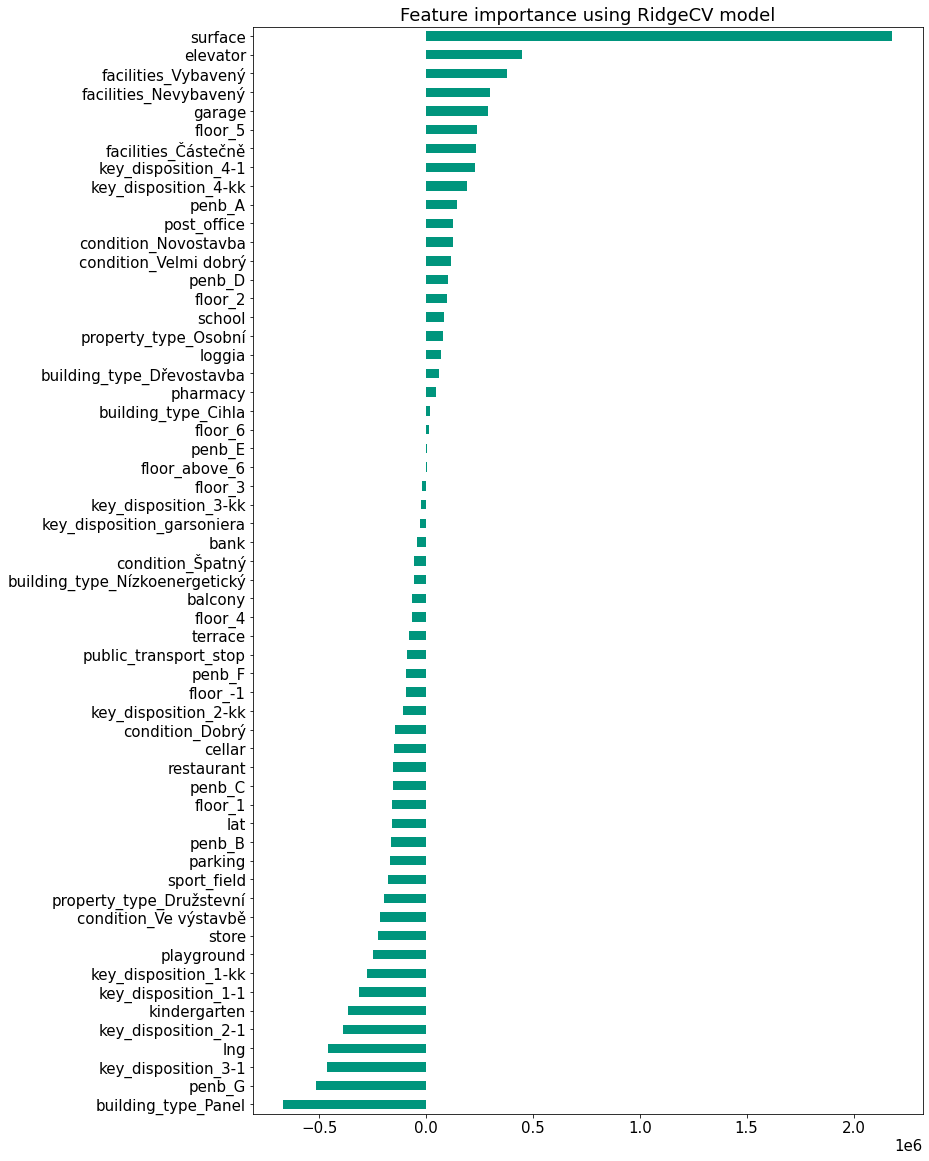

In [54]:
eval_lasso_ridge(X_sell, Y_sell, ridge_reg_sell, plot_feature_importance=True)

## Classification models

In [55]:
# Models

SVC_model = SVC()
KNN_model = KNeighborsClassifier(n_neighbors=5)
GNB_model = GaussianNB()
DTC_model = DecisionTreeClassifier()
RFC_model = RandomForestClassifier(n_estimators=100)

models = [SVC_model, KNN_model, GNB_model, DTC_model, RFC_model]

In [56]:
df_rent = df[df['key_offer_type'] == 'pronajem']
df_rent.drop(['key_offer_type'], axis=1, inplace=True)

df_sell = df[df['key_offer_type'] == 'prodej']
df_sell.drop(['key_offer_type', 'utilities', 'deposit'], axis=1, inplace=True)

df_all = df.copy()
df_all.drop(['key_offer_type', 'utilities', 'deposit'], axis=1, inplace=True)

dfs = [df_rent, df_sell, df_all]

### Predicting energy class PENB

In [57]:
dummies_attr = ['facilities', 'condition', 'property_type', 'building_type', 'key_disposition', 'floor']

In [58]:
eval_classification_by_offer_type(models, dfs, dummies_attr, 'penb')

******************************* RENT *******************************

SVC ------------------------------- 0.426 (43 %)
KNeighborsClassifier -------------- 0.376 (38 %)
GaussianNB ------------------------ 0.288 (29 %)
DecisionTreeClassifier ------------ 0.386 (39 %)
RandomForestClassifier ------------ 0.538 (54 %)


******************************* SELL *******************************

SVC ------------------------------- 0.524 (52 %)
KNeighborsClassifier -------------- 0.401 (40 %)
GaussianNB ------------------------ 0.134 (13 %)
DecisionTreeClassifier ------------ 0.436 (44 %)
RandomForestClassifier ------------ 0.59 (59 %)


******************************* ALL *******************************

SVC ------------------------------- 0.366 (37 %)
KNeighborsClassifier -------------- 0.296 (30 %)
GaussianNB ------------------------ 0.141 (14 %)
DecisionTreeClassifier ------------ 0.406 (41 %)
RandomForestClassifier ------------ 0.535 (54 %)




### Predicting building type

In [59]:
dummies_attr = ['facilities', 'condition', 'property_type', 'penb', 'key_disposition', 'floor']

In [60]:
eval_classification_by_offer_type(models, dfs, dummies_attr, 'building_type')

******************************* RENT *******************************

SVC ------------------------------- 0.637 (64 %)
KNeighborsClassifier -------------- 0.655 (66 %)
GaussianNB ------------------------ 0.32 (32 %)
DecisionTreeClassifier ------------ 0.672 (67 %)
RandomForestClassifier ------------ 0.76 (76 %)


******************************* SELL *******************************

SVC ------------------------------- 0.631 (63 %)
KNeighborsClassifier -------------- 0.61 (61 %)
GaussianNB ------------------------ 0.193 (19 %)
DecisionTreeClassifier ------------ 0.714 (71 %)
RandomForestClassifier ------------ 0.872 (87 %)


******************************* ALL *******************************

SVC ------------------------------- 0.656 (66 %)
KNeighborsClassifier -------------- 0.643 (64 %)
GaussianNB ------------------------ 0.146 (15 %)
DecisionTreeClassifier ------------ 0.669 (67 %)
RandomForestClassifier ------------ 0.807 (81 %)




### Predicting condition

In [61]:
dummies_attr = ['facilities', 'building_type', 'property_type', 'penb', 'key_disposition', 'floor']

In [62]:
eval_classification_by_offer_type(models, dfs, dummies_attr, 'condition')

******************************* RENT *******************************

SVC ------------------------------- 0.543 (54 %)
KNeighborsClassifier -------------- 0.486 (49 %)
GaussianNB ------------------------ 0.511 (51 %)
DecisionTreeClassifier ------------ 0.513 (51 %)
RandomForestClassifier ------------ 0.634 (63 %)


******************************* SELL *******************************

SVC ------------------------------- 0.567 (57 %)
KNeighborsClassifier -------------- 0.374 (37 %)
GaussianNB ------------------------ 0.241 (24 %)
DecisionTreeClassifier ------------ 0.521 (52 %)
RandomForestClassifier ------------ 0.642 (64 %)


******************************* ALL *******************************

SVC ------------------------------- 0.458 (46 %)
KNeighborsClassifier -------------- 0.415 (42 %)
GaussianNB ------------------------ 0.173 (17 %)
DecisionTreeClassifier ------------ 0.5 (50 %)
RandomForestClassifier ------------ 0.588 (59 %)




## Clustering models

### Location Clusters (rent + sell)

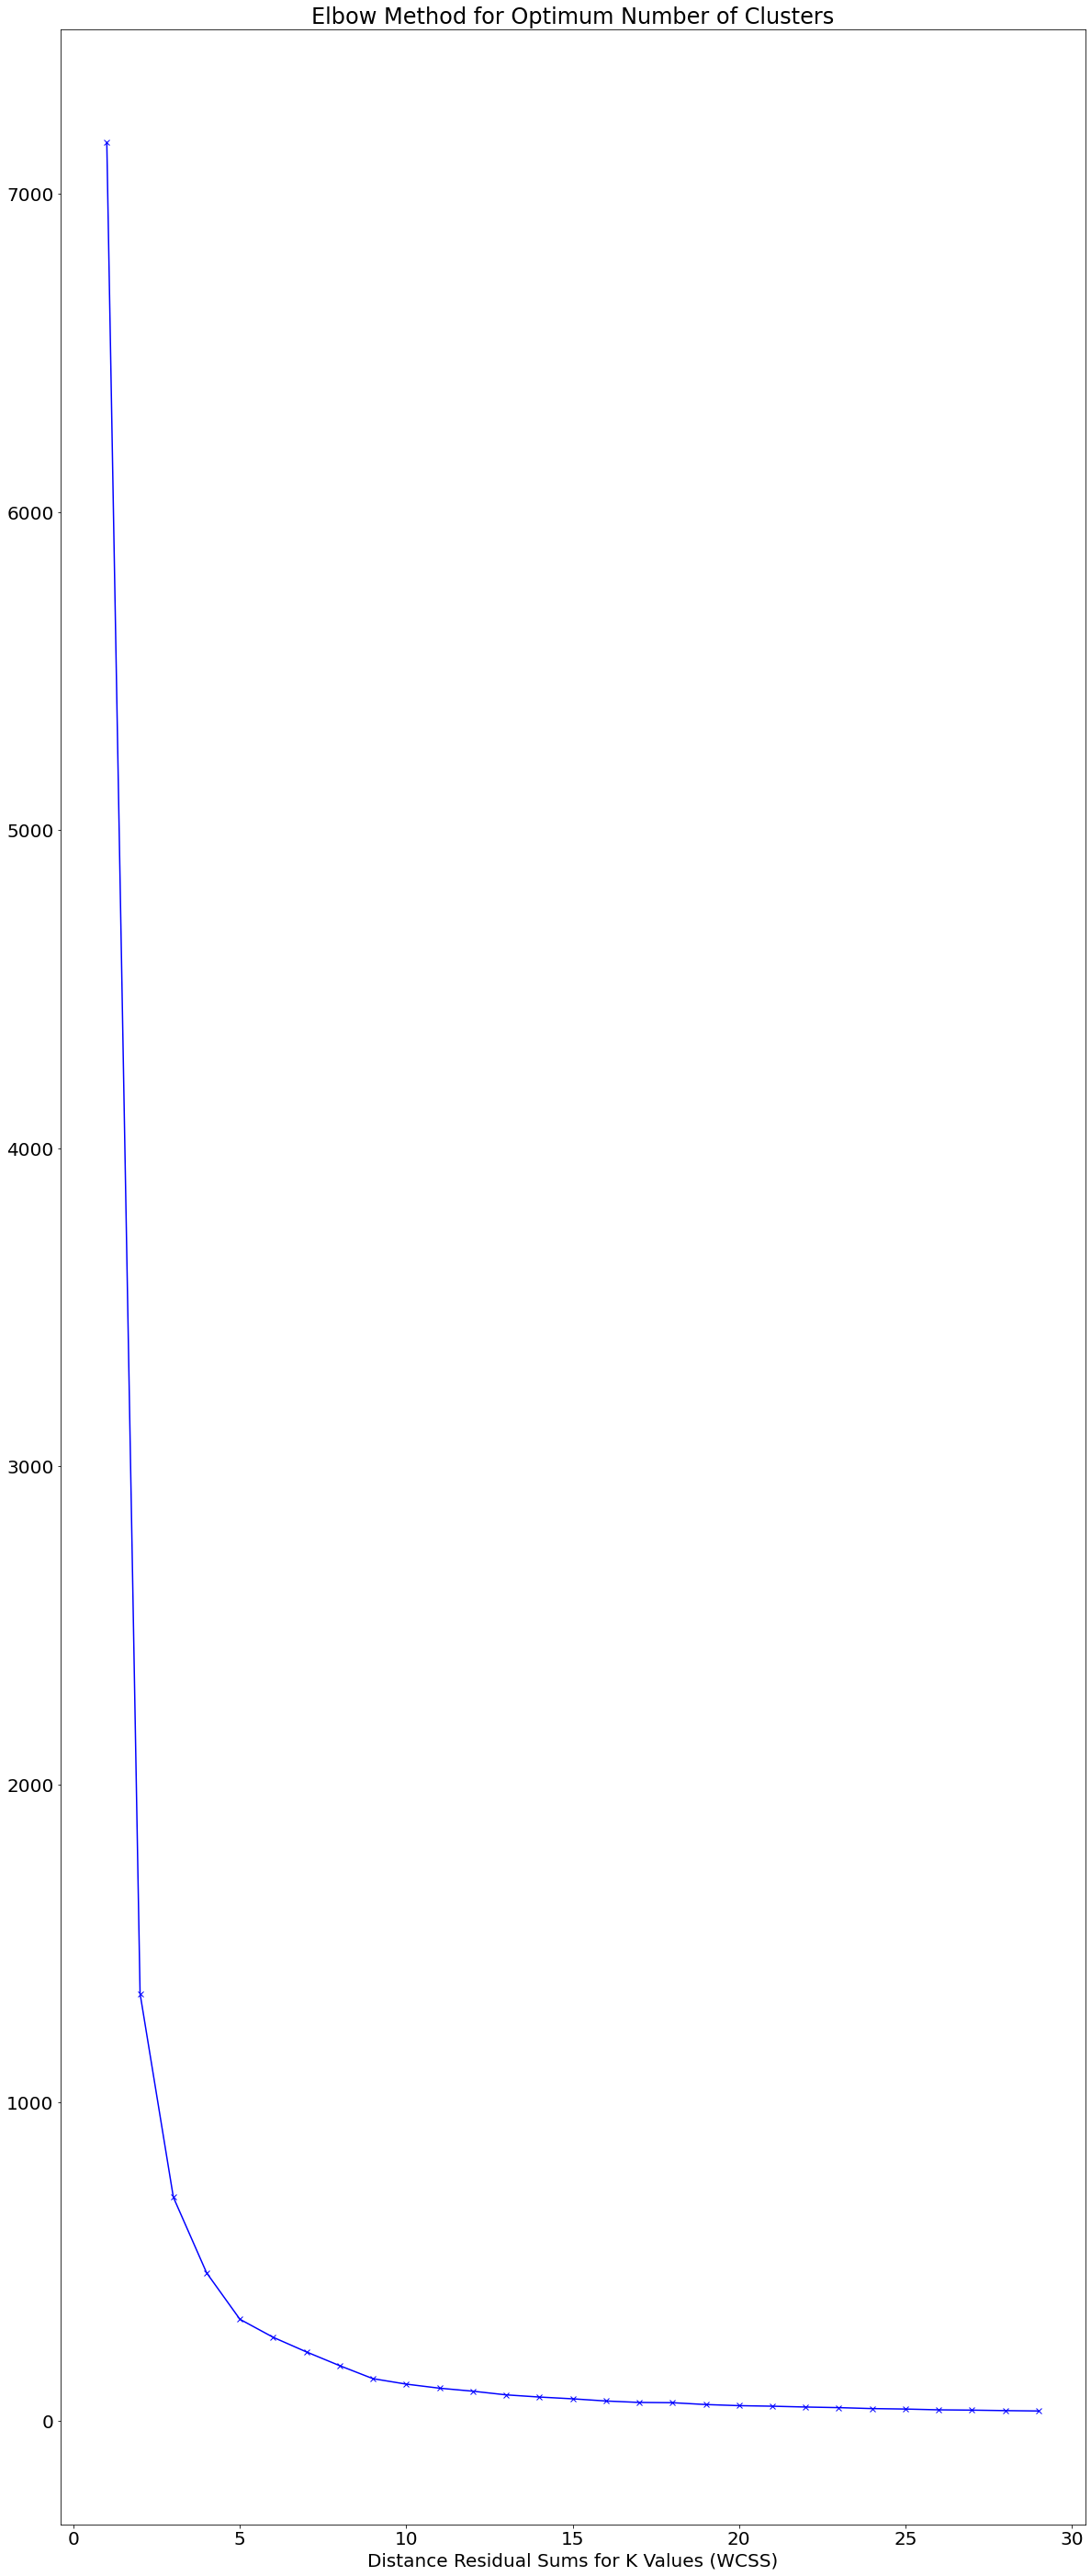

In [63]:
df_coord = df_all[['lat', 'lng']]

find_optimum_n_clusters_elbow(df_coord)

In [64]:
kmeans1 = evaluate_kmeans(df_coord, 3)

Silhouette score for 3 clusters --------- 0.772


In [65]:
df_copy = df.copy()
df_copy['cluster'] = kmeans1.fit_predict(df_coord)

df_copy.to_excel('location_clusters.xlsx')

### Clustering by price and surface (sell)

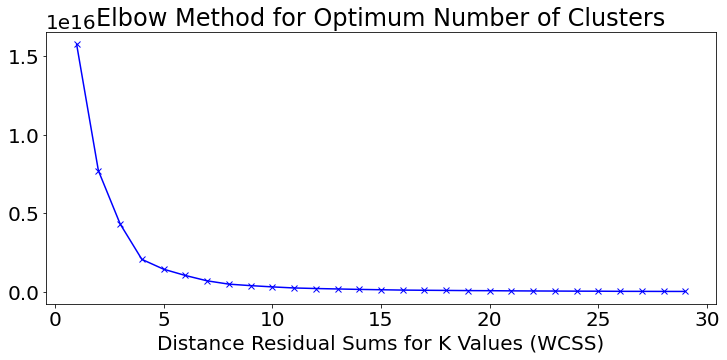

In [66]:
df_sell_part = df_sell[['price', 'surface']]

find_optimum_n_clusters_elbow(df_sell_part)

In [67]:
kmeans2 = evaluate_kmeans(df_sell_part, 2)

Silhouette score for 2 clusters --------- 0.667


In [69]:
df_sell_part['cluster'] = kmeans2.fit_predict(df_sell_part)

clusters_df = create_df_with_clusters(df_sell_part, attr_type='num')
clusters_df

,cluster,count,price,surface
0,cluster_1,818,5299450.0,57.0
1,cluster_2,113,12420000.0,91.0


In [ ]:
df_sell_clusters = df_sell.copy()
df_sell_clusters['cluster'] = kmeans2.fit_predict(df_sell_part)

In [ ]:
df_sell_clusters.to_excel('clusters_sell.xlsx')

### Clustering by price, surface, utilities and deposit (rent)

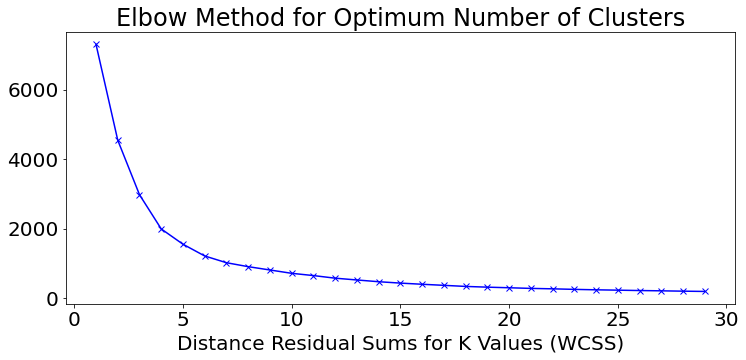

In [70]:
df_rent_part = df_rent[['price', 'surface', 'utilities', 'deposit']]

pca = PCA(2)
scaler = StandardScaler()

df_rent_part = pd.DataFrame(scaler.fit_transform(df_rent_part), columns=df_rent_part.columns)
df_rent_part_pca = pd.DataFrame(pca.fit_transform(df_rent_part))

find_optimum_n_clusters_elbow(df_rent_part_pca)

In [71]:
kmeans3 = evaluate_kmeans(df_rent_part_pca, 3)

Silhouette score for 3 clusters --------- 0.564


In [72]:
df_rent_part = df_rent[['price', 'surface', 'utilities', 'deposit']]
df_rent_part['cluster'] = kmeans3.fit_predict(df_rent_part_pca)

clusters_df = create_df_with_clusters(df_rent_part, attr_type='num')
clusters_df

,cluster,count,price,surface,utilities,deposit
0,cluster_1,279,24000.0,83.0,5000.000000,40000.0
1,cluster_2,1694,12500.0,47.0,3000.000000,19000.0
2,cluster_3,247,6550.0,51.0,10916.666667,13100.0


In [73]:
df_rent_clusters = df_rent.copy()
df_rent_clusters['cluster'] = kmeans3.fit_predict(df_rent_part_pca)

df_rent_clusters.to_excel('rent_clusters.xlsx')

### Clustering by area info attributes (rent + sell)

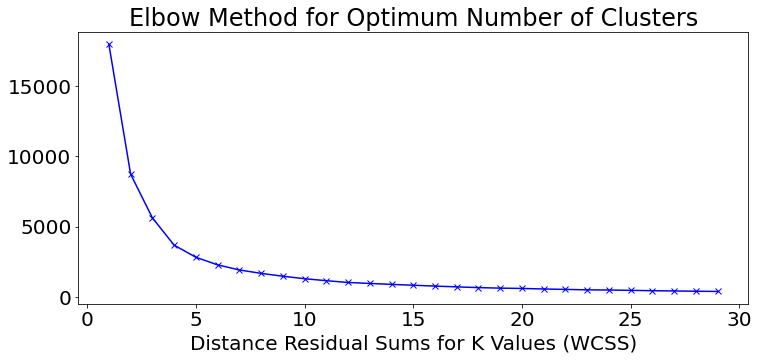

In [74]:
df_all_area_info = df[AREA_INFO_ATTRIBUTES]

pca = PCA(2)
scaler = StandardScaler()

df_all_area_info = pd.DataFrame(scaler.fit_transform(df_all_area_info), columns=df_all_area_info.columns)
df_all_area_info_pca = pd.DataFrame(pca.fit_transform(df_all_area_info))

find_optimum_n_clusters_elbow(df_all_area_info_pca)

In [75]:
kmeans4 = evaluate_kmeans(df_all_area_info_pca, 2)

Silhouette score for 2 clusters --------- 0.836


In [76]:
df_all_area_info = df[AREA_INFO_ATTRIBUTES]

df_all_area_info['cluster'] = kmeans4.fit_predict(df_all_area_info_pca)

In [77]:
clusters_df = create_df_with_clusters(df_all_area_info, attr_type='num')
clusters_df

,cluster,count,public_transport_stop,post_office,store,bank,restaurant,pharmacy,school,kindergarten,sport_field,playground
0,cluster_1,3002,219.0,646.5,268.0,688.5,289.0,466.0,443.5,579.5,734.0,339.5
1,cluster_2,149,395.0,1700.0,1430.0,6500.0,1397.0,4700.0,3300.0,4300.0,4200.0,2300.0


In [78]:
df_area_clusters = df_all.copy()
df_area_clusters['cluster'] = kmeans3.fit_predict(df_all_area_info_pca)

df_area_clusters.to_excel('area_clusters.xlsx')

### Clustering by all numeric attributes

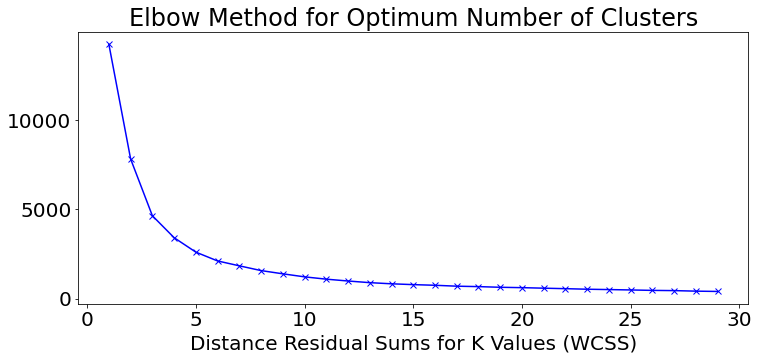

In [79]:
df_part = df_rent[['lat', 'lng', 'surface',
       'utilities', 'public_transport_stop',
       'post_office', 'store', 'bank', 'restaurant', 'pharmacy', 'school',
       'kindergarten', 'sport_field', 'playground', 'deposit']]

pca = PCA(2)
scaler = StandardScaler()

df_part = pd.DataFrame(scaler.fit_transform(df_part), columns=df_part.columns)
df_part = pd.DataFrame(pca.fit_transform(df_part))

find_optimum_n_clusters_elbow(df_part)

In [80]:
kmeans5 = evaluate_kmeans(df_part, 3)

Silhouette score for 3 clusters --------- 0.555


In [81]:
clusters = kmeans5.fit_predict(df_part)
df_part = df_rent[['lat', 'lng', 'surface',
       'utilities', 'public_transport_stop',
       'post_office', 'store', 'bank', 'restaurant', 'pharmacy', 'school',
       'kindergarten', 'sport_field', 'playground', 'deposit']]
df_part['cluster'] = clusters

In [82]:
clusters_df = create_df_with_clusters(df_part, attr_type='num')
clusters_df

,cluster,count,lat,lng,surface,utilities,public_transport_stop,post_office,store,bank,restaurant,pharmacy,school,kindergarten,sport_field,playground,deposit
0,cluster_1,628,49.735278,17.885655,49.0,4000.0,253.0,614.0,325.5,766.0,344.0,467.0,474.5,583.0,823.5,395.0,15000.0
1,cluster_2,73,50.051060,14.417025,43.0,3000.0,395.0,2200.0,2300.0,6400.0,1600.0,5000.0,3500.0,4400.0,4700.0,2700.0,18000.0
2,cluster_3,1519,50.078068,14.446890,51.0,3000.0,206.0,655.0,243.0,621.0,247.0,456.0,423.0,600.0,690.0,329.0,20000.0


### Clustering by categorical attributes (rent)

In [83]:
df_cat = df_rent.copy()

df_cat['price_bin'] = pd.cut(df_cat['price'], [0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 
                                               35_000, 40_000, 45_000, 50_000, 150_000], 
                              labels=['0K-5K', '5K-10K', '10K-15K', '15K-20K','20K-25K', '25K-30K',
                                      '30K-35K', '35K-40K', '40K-45K', '45K-50K', '>50K'], 
                              right=True, 
                              ordered=True)

df_cat['surface_bin'] = pd.cut(df_cat['surface'], [0, 20, 30, 40, 50, 60, 
                                               70, 80, 90, 100, 110, 350], 
                              labels=['0-20', '20-30', '30-40', '40-50','50-60', '60-70',
                                      '70-80', '80-90', '90-100', '100-110', '>110'], 
                              right=True, 
                              ordered=True)

df_cat['utilities_bin'] = pd.cut(df_cat['utilities'], [0, 1000, 2000, 3000, 4000, 5000, 6000, 
                                                       7000, 8000, 9000, 10000, 20000], 
                              labels=['0-1K', '1K-2K', '2K-3K', '3K-4K','4K-5K', '5K-6K',
                                      '6K-7K', '7K-8K', '8K-9K', '9K-10K', '>10K'], 
                              right=True, 
                              ordered=True)

df_cat['deposit_bin'] = pd.cut(df_cat['deposit'], [0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 
                                                   35_000, 40_000, 200_000], 
                              labels=['0K-5K', '5K-10K', '10K-15K', '15K-20K','20K-25K', '25K-30K',
                                      '30K-35K', '35K-40K', '>40K'], 
                              right=True, 
                              ordered=True)


df_cat['floor'] = df_cat['floor'].astype('str')

df_cat.drop(['price', 'surface', 'utilities', 'deposit', 'lat', 'lng'] + AREA_INFO_ATTRIBUTES, 
            axis=1, inplace=True)

for attribute in df_cat.columns:
    df_cat[attribute] = df_cat[attribute].astype('category')
    

In [84]:
df_cat.head()

,key_disposition,facilities,floor,balcony,terrace,cellar,loggia,parking,elevator,garage,condition,property_type,building_type,penb,price_bin,surface_bin,utilities_bin,deposit_bin
0,1-kk,Vybavený,6,1,0,0,0,0,1,1,None,Osobní,None,None,20K-25K,30-40,7K-8K,35K-40K
1,1-1,Vybavený,1,1,0,1,0,1,1,0,Velmi dobrý,Osobní,Cihla,G,5K-10K,30-40,3K-4K,5K-10K
2,3-kk,Vybavený,2,0,0,0,1,0,0,0,Dobrý,Osobní,Cihla,G,15K-20K,70-80,5K-6K,20K-25K
3,2-kk,Vybavený,1,0,0,0,0,0,0,0,None,Osobní,None,None,35K-40K,50-60,>10K,>40K
4,3-1,None,5,1,0,1,0,1,0,0,Velmi dobrý,Osobní,Panel,D,5K-10K,70-80,>10K,15K-20K


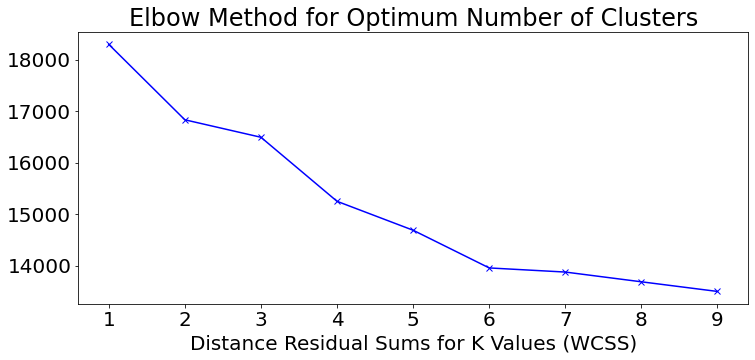

In [85]:
find_optimum_n_clusters_elbow(df_cat, kmodes=True)

In [86]:
kmodes = KModes(n_clusters=5, n_init=5).fit(df_cat)
df_cat['cluster'] = kmodes.fit_predict(df_cat)

In [87]:
clusters_df = create_df_with_clusters(df_cat, attr_type='cat')
clusters_df

,cluster,count,key_disposition,facilities,floor,balcony,terrace,cellar,loggia,parking,elevator,garage,condition,property_type,building_type,penb,price_bin,surface_bin,utilities_bin,deposit_bin
0,cluster_1,1085,2-kk,Částečně,2,0,0,0,0,0,0,0,Velmi dobrý,Osobní,Cihla,G,10K-15K,40-50,2K-3K,15K-20K
1,cluster_2,361,1-kk,Vybavený,4,0,0,1,0,0,1,0,Velmi dobrý,Osobní,Panel,G,5K-10K,30-40,1K-2K,10K-15K
2,cluster_3,246,2-kk,Částečně,1,1,0,0,0,1,1,0,Novostavba,Osobní,Cihla,B,15K-20K,50-60,3K-4K,20K-25K
3,cluster_4,238,2-1,Částečně,3,1,0,1,0,0,1,0,Velmi dobrý,Osobní,Cihla,G,15K-20K,60-70,3K-4K,25K-30K
4,cluster_5,290,2-1,None,1,0,0,1,0,1,0,0,Dobrý,Osobní,Cihla,E,5K-10K,50-60,>10K,10K-15K


## Anomaly Detection

In [221]:
df_c = df_rent[['price', 'surface', 'utilities'] + AREA_INFO_ATTRIBUTES]
scaler = StandardScaler()
df_c = scaler.fit_transform(df_c)

In [222]:
model = IsolationForest(random_state=47)

param_grid = {'n_estimators': [100, 1500], 
              'max_samples': [10], 
              'contamination': ['auto', 0.0001, 0.0002], 
              'max_features': [2, 15], 
              'bootstrap': [True], 
              'n_jobs': [-1]}

grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", refit=True, cv=10, 
                                           return_train_score=True)

best_model = grid_search.fit(df_c)
print('Optimum parameters', best_model.best_params_)

Optimum parameters {'bootstrap': True, 'contamination': 'auto', 'max_features': 2, 'max_samples': 10, 'n_estimators': 100, 'n_jobs': -1}


In [238]:
model = IsolationForest(n_estimators=100, max_samples=10, contamination=0.0001, max_features=10, n_jobs=-1, random_state=17)
model.fit(df_c)

IsolationForest(contamination=0.0001, max_features=10, max_samples=10,
                n_jobs=-1, random_state=17)

In [239]:
df_c2 = df_rent[['price', 'surface', 'utilities'] + AREA_INFO_ATTRIBUTES]
df_c2['anomaly'] = model.fit_predict(df_c)

In [240]:
df_c2[df_c2['anomaly'] == -1]

,price,surface,utilities,public_transport_stop,post_office,store,bank,restaurant,pharmacy,school,kindergarten,sport_field,playground,anomaly
175,9000,60,2500.0,5000,2200,7200,8400,6900,8400,4400,7900,7300,4700,-1
